<a href="https://colab.research.google.com/github/imirenechen/DS-Projects/blob/main/Project-8%20YOLOv1_voc%20Learning%20Rate%20Effect.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Please download all the necessary files from the following link:

~~https://drive.google.com/open?id=1XTjVnbUzdBYsI99kd8TYZSZYU4W1K7hd~~

Don't use the above link (2021/08 revision).

The files required by this colab file and can be run correctly is the following link:
~~https://drive.google.com/file/d/1JDI9l0YYiaW_U3UEuoMeMJ9Mloba4OJ5/view?usp=sharing~~

However, because uploading extracted files will take too much time, from 2022/5/01, this script is modified to download the zip files, unzip them on (1) this tempariry space or (2) "your google drive"!








In [ ]:
# update gdown for compatibility issue. 2022/12/12
!pip install --upgrade gdown

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.6.6
    Uninstalling gdown-4.6.6:
      Successfully uninstalled gdown-4.6.6


In [ ]:
from google.colab import drive
import os

# The flag to determine where to put the downloaded files.
# True: zip file will be downloaded to this space
# False:
# manually download file folder from https://drive.google.com/file/d/14KWN84l4O4jSaiFMGnjvw7oauUN7YOn1/view?usp=sharing
# unzip it and upload the folder-YOLO_data_model to the 1st level of your google drive which is actually "/content/drive/My Drive/"
In_this_space_flag = True

if In_this_space_flag == True and os.path.isdir("/content/YOLO_data_model/") == False:
# 1 do everything in this temporary space
  print('here')
  os.system("gdown https://drive.google.com/uc?id=14KWN84l4O4jSaiFMGnjvw7oauUN7YOn1")
  os.system("unzip YOLO_data_model.zip")
  os.remove("YOLO_data_model.zip")
elif In_this_space_flag == False: # and os.path.isdir("/content/drive/My Drive/YOLO_data_model/") == True:   
  drive.mount('/content/drive')
  assert os.path.isdir("/content/drive/My Drive/YOLO_data_model/") == True


here


/content/YOLO_data_model/VOCdevkit/VOC2007/JPEGImages/000001.jpg


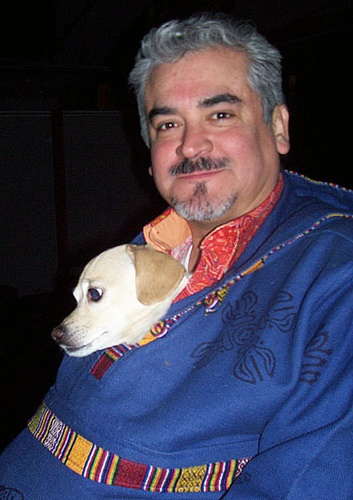

In [ ]:
#from google.colab import drive
#drive.mount("/content/drive", force_remount=True)
#drive.mount('/content/gdrive')

from google.colab.patches import cv2_imshow

import cv2 as cv

if In_this_space_flag == True:
  ## version 1: download file 
  # data folder
  VOC_root_dir = "/content/YOLO_data_model/"
else:
  ## version 2: download file 
  # data folder
  VOC_root_dir = "/content/drive/My Drive/YOLO_data_model/"

# Let's try to shown an image for making sure that all the data under the folder-YOLO_data_model is accessible.
img_path = VOC_root_dir + "VOCdevkit/VOC2007/JPEGImages/000001.jpg"
print(img_path)

img1_rgb = cv.imread(img_path) 

cv2_imshow(img1_rgb)

In [ ]:
import torch
import torch.optim as optim
from tqdm import tqdm
import numpy as np
from torchvision import transforms
import time
import os

classes = ["aeroplane", "bicycle", "bird", "boat", "bottle", "bus", "car", "cat",
           "chair", "cow", "diningtable", "dog", "horse", "motorbike", "person",
           "pottedplant", "sheep", "sofa", "train", "tvmonitor"]

bbox_num = 2
box_scale = 7
lr = 0.1e-3 # do remember that this is the initial learning rate; multifixed learning rate is manually written in the training loop


# Do remember that GT of training and testing data are given in two separate ways.
# In VOC2007_trainval.txt, every training jpg file and its corresponding GT (under /content/drive/MyDrive/YOLO_data_model/VOCdevkit/VOC2007/Label) are listed line-by-line.
# So did VOC2007_test.txt. However, in test_result(), although the same data loader (VOCDatasets()) is used, only image file names are used for performing image inference.
# The inference results are stored under detection_result_txt_folder = "/content/drive/MyDrive/YOLO_data_model/detection_temp_folder/".
# Then, mAP is estimated by reading the testing file list-test.txt under "/content/drive/MyDrive/YOLO_data_model/VOCdevkit/VOC2007/ImageSets/Main/"
# and the filenames (no extension) listed line-by-line will be used to read GT (stored in xml files) under "/content/drive/MyDrive/YOLO_data_model/VOCdevkit/VOC2007/Annotation/".
# The GT loaded in terms of pkls for mAP estimation is put under GT_temp_folder = "/content/drive/MyDrive/YOLO_data_model/GT_temp/". 


# training image list
train_image_list = VOC_root_dir + "VOC2007_train.txt"
# tesing image list
eval_image_list = VOC_root_dir + "VOC2007_test.txt"
# folder for training or trained models
model_path = VOC_root_dir + "trained_YOLO_model/"
# pretrained model (darknet19)
pretrain_path = VOC_root_dir + "darknet19_448.conv.23"


# folder for detection result to be used for estimating mAP
detection_result_txt_folder = VOC_root_dir + "detection_temp_folder/"
# folder to store temp GT data (pkl files)
GT_temp_folder = VOC_root_dir + "GT_temp/" 
# log file for mAP estimation corresponding to each epoch
savelog_filename = VOC_root_dir + "savelog.txt"

# model_save_iter = 1  # epochs
epochs_start = 1 #0
epochs_end = 10 #150 #原本檔案寫50
batch_size =  12 #24 originally # the size depends on the RAM of GPU
cls_num = len(classes)

# data augmentation
jitter = 0.2
hue = 0.1
saturation = 1.5
exposure = 1.5

# weightings of loss
l_coord = 5
l_noobj = 0.5

YOLO_cfg = {
    'ceils_size':7,
    'class_num':len(classes),
    'box_num':2,
    'image_size':[448,448]
}

In [ ]:
# Model definition
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torch.autograd import Variable

layer_configs = [
        # Unit1 (2)
        (32, 3, True),
        (64, 3, True),
        # Unit2 (3)
        (128, 3, False),
        (64, 1, False),
        (128, 3, True),
        # Unit3 (3)
        (256, 3, False),
        (128, 1, False),
        (256, 3, True),
        # Unit4 (5)
        (512, 3, False),
        (256, 1, False),
        (512, 3, False),
        (256, 1, False),
        (512, 3, True),
        # Unit5 (5)
        (1024, 3, False),
        (512, 1, False),
        (1024, 3, False),
        (512, 1, False),
        (1024, 3, False),
]


class conv_block(nn.Module):
    
    def __init__(self,inplane,outplane,kernel_size,pool,stride=1):
        super(conv_block, self).__init__()
        
        pad = 1 if kernel_size == 3 else 0
        self.conv = nn.Conv2d(inplane, outplane, kernel_size, stride=stride, padding=pad, bias=False)
        self.bn = nn.BatchNorm2d(outplane)
        self.act = nn.LeakyReLU(0.1)
        self.pool = pool #MaxPool2d(2,stride = 2)
        
    def forward(self,x):    
        
        out = self.conv(x)
        out = self.bn(out)
        out = self.act(out)
        
        if self.pool:
            out = F.max_pool2d(out,kernel_size=2,stride=2)
            
        return out


class darknet_19(nn.Module):
    
    def __init__(self,cls_num = 1000):
        super(darknet_19, self).__init__()
        self.class_num = cls_num
        self.feature = self.make_layers(3,layer_configs)

            
    def make_layers(self,inplane,cfg):
        layers = []

        for outplane,kernel_size,pool in cfg:
            layers.append(conv_block(inplane,outplane,kernel_size,pool))
            inplane = outplane
            
            
        return nn.Sequential(*layers)
          
    def load_weight(self,weight_file):
        print("Load pretrained models !")

        fp = open(weight_file, 'rb')
        header = np.fromfile(fp, count=4, dtype=np.int32)
        header = torch.from_numpy(header)
        buf = np.fromfile(fp, dtype = np.float32)
        
        start = 0
        for idx,m in enumerate(self.feature.modules()):
            if isinstance(m, nn.Conv2d):
                conv = m
            if isinstance(m, nn.BatchNorm2d):
                bn = m
                start = load_conv_bn(buf,start,conv,bn)

        assert start == buf.shape[0]
        
    def forward(self, x):
        
        output = self.feature(x)
        
        return output    
    
class YOLO(nn.Module):

    def __init__(self,cls_num,bbox_num = 2,scale_size = 7, pretrained = None):
        super(YOLO, self).__init__()
        
        self.cls_num = cls_num
        self.feature = darknet_19()
        #self.conv_model = conv_model
        if pretrained is not None :
            self.feature.load_weight(pretrained)
            
            
        self.scale_size = scale_size
        self.bbox_num = bbox_num 
        self.last_output = (5*self.bbox_num+self.cls_num)

        cx = torch.linspace(0.5 / scale_size, (scale_size-0.5) / scale_size, steps=scale_size).\
            view(-1, scale_size).repeat(scale_size, 1).view(scale_size, scale_size, -1)
        cy = torch.linspace(0.5 / scale_size, (scale_size-0.5) / scale_size, steps=scale_size).\
            view(scale_size, -1).repeat(1, scale_size).view(scale_size, scale_size, -1)
        self.anchor = torch.cat((cx, cy), 2)
        
        self.local_layer = nn.Sequential()
        
        self.local_layer.add_module('block_1',conv_block(1024,1024,3,False,2))
        
        self.local_layer.add_module('block_2',conv_block(1024,1024,3,False,1))
        
        self.local_layer.add_module('block_3',conv_block(1024,1024,3,False,1))
        
        self.local_layer.add_module('block_4',conv_block(1024,1024,3,False,1))
        

        self.reg_layer = nn.Sequential()

        self.reg_layer.add_module('local_layer', nn.Linear(1024*7*7, 4096))
        self.reg_layer.add_module('leaky_local', nn.LeakyReLU(0.1, inplace=True))
        self.reg_layer.add_module('dropout', nn.Dropout(0.5) )
        self.reg_layer.add_module('fc_1', nn.Linear(4096, (5*self.bbox_num+self.cls_num)*self.scale_size*self.scale_size ))
    
    def forward(self,x):
        B = x.size(0)
        output = self.feature(x)
        output = self.local_layer(output)
        
        output = output.view(output.data.size(0),-1)
            
        output = self.reg_layer(output)

        output = output.view(-1,self.bbox_num*5+self.cls_num,self.scale_size,self.scale_size)

        output = output.permute(0,2,3,1).contiguous()
        
        pred_cls = output[:, :, :, :self.cls_num]
        pred_bbox = torch.cat(
            [output[:, :, :, self.cls_num + 5*j:self.cls_num + 4 + 5*j ] for j in range(self.bbox_num)],
            -1)
        pred_response = torch.cat([output[:, :, :, self.cls_num + 4 + 5*j:self.cls_num + 4+ 5*j +1]
                                   for j in range(self.bbox_num)], -1)
        anchors = self.anchor.repeat((B, 1, 1, 1)).to(pred_bbox.device)
        pred_bbox[:,:,:,0:2] += anchors
        
        return pred_cls,pred_response,pred_bbox
        


def load_conv_bn(buf, start, conv_model, bn_model):
    num_w = conv_model.weight.numel()

    num_b = bn_model.bias.numel()
    bn_model.bias.data.copy_(torch.from_numpy(buf[start:start+num_b]));     start = start + num_b
    bn_model.weight.data.copy_(torch.from_numpy(buf[start:start+num_b]));   start = start + num_b
    bn_model.running_mean.copy_(torch.from_numpy(buf[start:start+num_b]));  start = start + num_b
    bn_model.running_var.copy_(torch.from_numpy(buf[start:start+num_b]));   start = start + num_b

    conv_weight = torch.from_numpy(buf[start:start+num_w])
    conv_model.weight.data.copy_(conv_weight.view_as(conv_model.weight)); start = start + num_w 
    return start

In [ ]:
# load pretrained model (Darknet-19) or unfinished trained model
if epochs_start == 1:
    net = YOLO(cls_num, bbox_num, box_scale, pretrained=pretrain_path)
else:
    net = YOLO(cls_num, bbox_num, box_scale)

net.cuda()
net.train()


if epochs_start > 1:
    net.load_state_dict(torch.load(model_path + 'model_.pkl'))
    
print("load model successfully")

Load pretrained models !
load model successfully


In [ ]:
# BBox encoder, decoder for the last layer (7*7*30) and Non-Maximal Suppression

def yolo_box_encoder(bs):

    bb_class = np.zeros((YOLO_cfg['ceils_size'], YOLO_cfg['ceils_size'], YOLO_cfg['class_num']))
    bb_response = np.zeros((YOLO_cfg['ceils_size'], YOLO_cfg['ceils_size'], YOLO_cfg['box_num']))
    bb_boxes = np.zeros((YOLO_cfg['ceils_size'], YOLO_cfg['ceils_size'], 4 * YOLO_cfg['box_num']))

    for i in range(bs.shape[0]):

        local_x = int( min(0.99,bs[i,0] + bs[i,2] / 2) * YOLO_cfg['ceils_size'])
        local_y = int( min(0.99,bs[i,1] + bs[i,3] / 2) * YOLO_cfg['ceils_size'])

        for j in range(YOLO_cfg['box_num']):
            bb_response[local_y, local_x, j] = 1

            bb_boxes[local_y, local_x, j * 4 + 0] = (bs[i,0] + bs[i,2] /2)
            bb_boxes[local_y, local_x, j * 4 + 1] = (bs[i,1] + bs[i,3] /2)
            bb_boxes[local_y, local_x, j * 4 + 2] = np.sqrt(bs[i,2])
            bb_boxes[local_y, local_x, j * 4 + 3] = np.sqrt(bs[i,3])

        bb_class[local_y, local_x, int(bs[i,4])] = 1

    bb_boxes = torch.from_numpy(bb_boxes).float()
    bb_class = torch.from_numpy(bb_class).float()
    bb_response = torch.from_numpy(bb_response).float()
    boxes = (bb_class,bb_response,bb_boxes)

    return boxes

def py_cpu_nms(dets, scores, thresh):
    # dets:(m,5)  thresh:scaler
    #print(scores.shape)
    temp_len = 0  # np.max(dets[:,2]) * 0.05

    x1 = dets[:, 0]
    y1 = dets[:, 1]
    x2 = x1 + dets[:, 2]  # dets[:, 2]#
    y2 = y1 + dets[:, 3]  # dets[:, 3]#

    areas = (y2 - y1 + temp_len) * (x2 - x1 + temp_len)

    keep = []

    index = scores.argsort()[::-1][:200]


    while index.size > 0:
        i = index[0]  # every time the first is the biggst, and add it directly
        keep.append(i)

        x11 = np.maximum(x1[i], x1[index[1:]])  # calculate the points of overlap
        y11 = np.maximum(y1[i], y1[index[1:]])
        x22 = np.minimum(x2[i], x2[index[1:]])
        y22 = np.minimum(y2[i], y2[index[1:]])

        w = np.maximum(0, x22 - x11 + temp_len)  # the weights of overlap
        h = np.maximum(0, y22 - y11 + temp_len)  # the height of overlap

        overlaps = w * h
        #assert overlaps.all() >= 0
        ious = overlaps / (areas[i] + areas[index[1:]] - overlaps)

        idx = np.where(ious <= thresh)[0]
        index = index[idx + 1]

    return keep

def yolo_box_decoder(pred,conf_thresh=0.01,nms_thresh=0.5):
    box_scale = YOLO_cfg['ceils_size']
    cls_num = YOLO_cfg['class_num']
    box_num = YOLO_cfg['box_num']
    
    pred_cls, pred_response, pred_bboxes = pred
    
    pred_cls = pred_cls.cpu()
    pred_response = pred_response.cpu()
    pred_bboxes = pred_bboxes.cpu()

    prob = pred_response
    max_prob, max_prob_index = prob.max(3)
    boxes = []
    classes = []
    

    max_prob_index = max_prob_index.permute(1,2,0)
    for B in range(1):
        for cls in range(cls_num):

            cls_prob = (pred_cls[B,:,:,cls]*max_prob[B, :, :]).data
            
            mask_box = torch.zeros((box_scale,box_scale,box_num))
            
            mask_box.scatter_(2,max_prob_index,1)
            mask_box = mask_box.unsqueeze(-1)

            mask_box = mask_box.repeat(1,1,1,4).view(box_scale,box_scale,box_num*4)
            mask_box = mask_box.unsqueeze(0).byte()
            mask_box = mask_box.expand_as(pred_bboxes)
            bbox = pred_bboxes[mask_box].data

            bbox = bbox.reshape(-1,4)
            cls_prob = cls_prob.reshape(-1,1)
            
            a = cls_prob.gt(conf_thresh)
            mask_a = a.expand_as(bbox)

            bbox = bbox[mask_a].reshape(-1,4)
            cls_prob = cls_prob[a].reshape(-1,1)

            if bbox.shape[0] > 0:   
                bbox[:,0:2] = bbox[:,0:2] - 0.5*torch.pow(bbox[:,2:4],2)
                bbox[:,2:4] = torch.pow(bbox[:,2:4],2)
                
                pre_cls_box = bbox.data.numpy()
                pre_cls_score = cls_prob.data.view(-1).numpy()
                
                keep = py_cpu_nms(pre_cls_box, pre_cls_score, thresh=nms_thresh)
                for conf_keep, loc_keep in zip(pre_cls_score[keep], pre_cls_box[keep]):
                    boxes.append(loc_keep)
                    classes.append([cls,conf_keep])

    boxes = np.array(boxes)
    classes = np.array(classes)

    return boxes,classes

In [ ]:
# data loader and data augmentation

from PIL import Image,ImageEnhance
from torch.utils import data
import random

def distort_image(im, hue, sat, val):
    im = im.convert('HSV')
    cs = list(im.split())
    cs[1] = cs[1].point(lambda i: i * sat)
    cs[2] = cs[2].point(lambda i: i * val)
    
    def change_hue(x):
        x += hue*255
        if x > 255:
            x -= 255
        if x < 0:
            x += 255
        return x
    cs[0] = cs[0].point(change_hue)
    im = Image.merge(im.mode, tuple(cs))

    im = im.convert('RGB')
    return im

def rand_scale(s):
    scale = random.uniform(1, s)
    if(random.randint(1,10000)%2): 
        return scale
    return 1./scale

def random_distort_image(im, hue, saturation, exposure):
    dhue = random.uniform(-hue, hue)
    dsat = rand_scale(saturation)
    dexp = rand_scale(exposure)
    res = distort_image(im, dhue, dsat, dexp)
    return res


def data_augmentation(img, shape, jitter, hue, saturation, exposure):
    oh = img.height  
    ow = img.width
    
    dw =int(ow*jitter)
    dh =int(oh*jitter)

    pleft  = random.randint(-dw, dw)
    pright = random.randint(-dw, dw)
    ptop   = random.randint(-dh, dh)
    pbot   = random.randint(-dh,dh)

        
    swidth =  ow - pleft - pright
    sheight = oh - ptop - pbot


    sx = float(swidth)  / ow
    sy = float(sheight) / oh
    
    flip = random.randint(1,10000)%2

    cropped = img.crop( (pleft, ptop, pleft + swidth - 1, ptop + sheight - 1))

    dx = (float(pleft)/ow)/sx
    dy = (float(ptop) /oh)/sy


    sized = cropped.resize(shape,Image.NEAREST)
    if flip: 
        sized = sized.transpose(Image.FLIP_LEFT_RIGHT)
    img = random_distort_image(sized, hue, saturation, exposure)
    
    return img, flip, dx,dy,sx,sy 

def fill_truth_detection(bs, flip, dx, dy, sx, sy):

    new_bs = []
    #print(bs)
    for i in range(bs.shape[0]):
        x1 = bs[i][0]
        y1 = bs[i][1]
        x2 = bs[i][0] + bs[i][2]
        y2 = bs[i][1] + bs[i][3]
        
        x1 = min(0.99, max(0, x1 * sx - dx)) 
        y1 = min(0.99, max(0, y1 * sy - dy)) 
            
        x2 = max(0, min(0.999, x2 * sx - dx))
        y2 = max(0, min(0.999, y2 * sy - dy))
            
        
        bs[i][0] = x1
        bs[i][1] = y1 
        bs[i][2] = x2 - x1
        bs[i][3] = y2 - y1
        bs[i][4] = bs[i][4]
        if flip:
            bs[i][0] =  1 - bs[i][0] - bs[i][2]
                
        if bs[i][2] > 0 and bs[i][3] > 0:
            new_bs.append([bs[i]])
   
    new_bs = np.array(new_bs)
    new_bs = np.reshape(new_bs, (-1, 5))

    return new_bs


def norm_bb(b,size):
    x = b[:, 0:1]
    y = b[:, 1:2]

    dw = 1. / size[0]
    dh = 1. / size[1]

    x = (x * dw).clip(0.01, 0.99)
    y = (y * dh).clip(0.01, 0.99)
    w = ((b[:, 2:3] - b[:, 0:1]) * dw).clip(0.01, 0.99)
    h = ((b[:, 3:4] - b[:, 1:2]) * dh).clip(0.01, 0.99)

    return np.concatenate((x, y, w, h, b[:, 4:5]), axis=1)

def load_data_detection(imgpath,labpath ,shape, aug = True, jitter=0.2, hue=0.1, saturation=1.5, exposure=1.5):

    #print('---imgpath={}'.format(imgpath))
    img = Image.open(imgpath).convert('RGB')

    bs = np.loadtxt(labpath,delimiter=',') 
    bs = np.reshape(bs, (-1, 5))
    
    bs = norm_bb(bs,(img.width,img.height))
    
    # data augmentation is applied only in training phase
    if aug:
        img, flip, dx, dy, sx, sy = data_augmentation(img, shape, jitter, hue, saturation, exposure)
    else:
        flip, dx, dy, sx, sy = False, 0, 0, 1, 1
        
    #print(dx, dy, sx, sy)
    label = fill_truth_detection(bs, flip, dx, dy, 1./sx, 1./sy)
    
    return img,label



class VOCDatasets(data.Dataset):
    def __init__(self, transform, list_file, VOC_root_dir, box_encoder = None, train=False):

        self.transform = transform
        self.train = train
        self.label_path = []
        self.image_path = []
        self.box_encoder = box_encoder
        with open(list_file) as f:
            lines = f.readlines()

        self.num_samples = len(lines)

        for line in lines:
            # using "__" instead of "__" because the data path under Google drive is all "/content/drive/MyDrive/...
            # Therefore, the following .split(' ') function would result in error
            # splited = line.strip().split(' ')            
            splited = line.strip().split('__')
            self.image_path.append(VOC_root_dir + splited[0])
            self.label_path.append(VOC_root_dir + splited[1])

    def __getitem__(self, idx):

        file_name = self.image_path[idx]
        gt_path = self.label_path[idx]

        #img,bbox = data_augment(file_name,gt_path,self.train)
        #print('--in __getitem__, file_name={}'.format(file_name))
        img, bbox = load_data_detection(file_name, gt_path, [448, 448], self.train)
        #maximum bbox=50

        if self.box_encoder is not None:
            gt = self.box_encoder(bbox)
        else:
            gt = np.zeros((50, 5), dtype=np.float32)
            gt[:len(bbox), :] = bbox
            gt = torch.from_numpy(gt).float()

        img = self.transform(img)*255

        return img,gt

    def __len__(self):
        return self.num_samples

# remember that the following tansform would only accept PIL images as input
transform = transforms.Compose([
    transforms.Resize([448, 448]),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [1, 1, 1])
])


dataset = VOCDatasets(transform, train_image_list, VOC_root_dir, yolo_box_encoder, train=True) # train=true will apply data augmentation

train_loader = data.DataLoader(dataset=dataset,
                              batch_size=batch_size,
                              shuffle=True,
                              num_workers=1)

In [ ]:
# YOLO loss

import torch
import torch.nn.functional as F
import torch.nn as nn
from torch.autograd import Variable

class yolov1_loss(nn.Module):
    def __init__(self, B, l_coord, l_noobj,device='cuda' ,cls_num=20):
        super(yolov1_loss, self).__init__()
        self.B = B # bbox_num
        self.l_coord = l_coord
        self.l_noobj = l_noobj
        self.class_num = cls_num
        self.device = device

    def compute_iou(self, box1, box2):
        '''Compute the intersection over union of two set of boxes, each box is [x1,y1,x2,y2].
        Args:
          box1: (tensor) bounding boxes, sized [N,4].
          box2: (tensor) bounding boxes, sized [M,4].
        Return:
          (tensor) iou, sized [N,M].
        '''

        lt = torch.max(
            box1[:, :2],  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:, :2],  # [M,2] -> [1,M,2] -> [N,M,2]
        )

        rb = torch.min(
            box1[:, 2:],  # [N,2] -> [N,1,2] -> [N,M,2]
            box2[:, 2:],  # [M,2] -> [1,M,2] -> [N,M,2]
        )

        wh = rb - lt  # [N,M,2]
        wh[wh < 0] = 0  # clip at 0
        inter = wh[:, 0] * wh[:, 1]  # [N,M]

        area1 = (box1[:, 2] - box1[:, 0]) * (box1[:, 3] - box1[:, 1])  # [N,]
        area2 = (box2[:, 2] - box2[:, 0]) * (box2[:, 3] - box2[:, 1])  # [M,]

        iou = inter / (area1 + area2 - inter)
        return iou

    def forward(self,pred,target):
        #print(target)
        pred_cls, pred_response, pred_bboxes = pred
        label_cls, label_response, label_bboxes = target


        pred_cls = pred_cls.to(self.device)
        pred_response =  pred_response.to(self.device)
        pred_bboxes = pred_bboxes.to(self.device)

        label_cls = label_cls.to(self.device)
        label_response =  label_response.to(self.device)
        label_bboxes = label_bboxes.to(self.device)


        batch_size = pred_response.size(0)

        no_obj_mask = (label_response[:, :, :, 0] < 1).unsqueeze(-1).expand_as(label_response)

        obj_response_mask = (label_response[:, :, :, 0] > 0).unsqueeze(-1).expand_as(label_response)

        obj_box_mask = (label_response[:, :, :, 0] > 0).unsqueeze(-1).expand_as(label_bboxes)

        obj_cls_mask = (label_response[:, :, :, 0] > 0).unsqueeze(-1).expand_as(label_cls)

        no_obj_contain_pred = pred_response[no_obj_mask].view(-1)
        no_obj_contain_target = label_response[no_obj_mask].view(-1)


        obj_contain_pred = pred_response[obj_response_mask].view(-1, self.B)

        obj_contain_target = label_response[obj_response_mask].view(-1, self.B)

        # class pred response
        obj_class_pred = pred_cls[obj_cls_mask].view(-1, self.class_num)
        obj_class_target = label_cls[obj_cls_mask].view(-1, self.class_num)

        # box pred response
        obj_loc_pred = pred_bboxes[obj_box_mask].view(-1, self.B * 4)
        obj_loc_target = label_bboxes[obj_box_mask].view(-1, self.B * 4)

        iou = torch.zeros(obj_loc_pred.size(0), self.B)
        iou = Variable(iou)

        for j in range(self.B):
            pred_bb = torch.zeros(obj_loc_pred.size(0), 4)
            pred_bb = Variable(pred_bb)

            target_bb = torch.zeros(obj_loc_pred.size(0), 4)
            target_bb = Variable(target_bb)

            target_bb[:, 0] = obj_loc_target[:, j * 4] - 0.5 * pow(obj_loc_target[:, j * 4 + 2], 2)
            target_bb[:, 1] = obj_loc_target[:, j * 4 + 1] - 0.5 * pow(obj_loc_target[:, j * 4 + 3], 2)
            target_bb[:, 2] = obj_loc_target[:, j * 4] + 0.5 * pow(obj_loc_target[:, j * 4 + 2], 2)
            target_bb[:, 3] = obj_loc_target[:, j * 4 + 1] + 0.5 * pow(obj_loc_target[:, j * 4 + 3], 2)

            pred_bb[:, 0] = obj_loc_pred[:, j * 4] - 0.5 * pow(obj_loc_pred[:, j * 4 + 2], 2)
            pred_bb[:, 1] = obj_loc_pred[:, j * 4 + 1] - 0.5 * pow(obj_loc_pred[:, j * 4 + 3], 2)
            pred_bb[:, 2] = obj_loc_pred[:, j * 4] + 0.5 * pow(obj_loc_pred[:, j * 4 + 2], 2)
            pred_bb[:, 3] = obj_loc_pred[:, j * 4 + 1] + 0.5 * pow(obj_loc_pred[:, j * 4 + 3], 2)

            iou[:, j] = self.compute_iou(target_bb, pred_bb)

        max_iou, max_index = iou.max(1)
        min_iou, _ = iou.min(1)
        max_index = max_index.data.cpu()

        coo_response_mask = torch.ByteTensor(obj_loc_pred.size(0), self.B * 4).to(self.device)

        coo_response_mask.zero_()
        for i in range(obj_loc_pred.size(0)):
            coo_response_mask[i, max_index[i] * 4:max_index[i] * 4 + 4] = 1

        obj_axis_pred = obj_loc_pred[coo_response_mask].view(-1, 4)
        obj_axis_target = obj_loc_target[coo_response_mask].view(-1, 4)

        iou_response_mask = coo_response_mask[:, [i * 4 for i in range(self.B)]]

        obj_response_pred = obj_contain_pred[iou_response_mask].view(-1)
        obj_response_target = obj_contain_target[iou_response_mask].view(-1)

        obj_local_loss = F.mse_loss(obj_axis_pred[:, 0:2], obj_axis_target[:, 0:2], size_average=False) + \
                         F.mse_loss(obj_axis_pred[:, 2:4], obj_axis_target[:, 2:4], size_average=False)
        obj_class_loss = F.mse_loss(obj_class_pred, obj_class_target, size_average=False)


        max_iou = (max_iou.data).to(self.device)
        conf_id = ((1 - max_iou) * self.l_noobj + max_iou).to(self.device)

        conf_id = Variable(conf_id, requires_grad=True)

        obj_contain_loss = F.mse_loss(obj_response_pred, max_iou, size_average=False)

        no_obj_contain_loss = F.mse_loss(no_obj_contain_pred, no_obj_contain_target, size_average=False)

        iou_loss = F.mse_loss(max_iou, obj_response_target, size_average=False)

        loss_all = (self.l_coord * obj_local_loss + obj_class_loss + obj_contain_loss + self.l_noobj * no_obj_contain_loss + iou_loss) / batch_size

        loss_info = {
            'local_loss': self.l_coord * obj_local_loss.data,
            'class_loss': obj_class_loss.data,
            'contain_loss': obj_contain_loss.data,
            'no_contain_loss': self.l_noobj * no_obj_contain_loss,
            'iou_loss': iou_loss,
            'mean_iou': torch.mean(max_iou)
        }

        return loss_all, loss_info

In [ ]:
# optimizer and loss

optimizer = optim.SGD(net.parameters(), lr=lr, momentum=0.9, weight_decay=5e-4)

device='cuda'

loss_detect = yolov1_loss(bbox_num, l_coord, l_noobj, device, cls_num)

# do remind the difference between step & epoch
step = epochs_start * len(train_loader)

best_score = 0
eval_score = 0

In [ ]:
# mAP estimation
import xml.etree.ElementTree as ET
import os
import pickle
import numpy as np
import cv2


def parse_rec(filename):
    """ Parse a PASCAL VOC xml file """
    tree = ET.parse(filename)
    objects = []
    for obj in tree.findall('object'):
        obj_struct = {}
        obj_struct['name'] = obj.find('name').text
        obj_struct['pose'] = obj.find('pose').text
        obj_struct['truncated'] = int(obj.find('truncated').text)
        obj_struct['difficult'] = int(obj.find('difficult').text)
        bbox = obj.find('bndbox')
        obj_struct['bbox'] = [int(bbox.find('xmin').text),
                              int(bbox.find('ymin').text),
                              int(bbox.find('xmax').text),
                              int(bbox.find('ymax').text)]
        objects.append(obj_struct)

    return objects


def voc_ap(rec, prec, use_07_metric=False):
    """ ap = voc_ap(rec, prec, [use_07_metric])
    Compute VOC AP given precision and recall.
    If use_07_metric is true, uses the
    VOC 07 11 point method (default:False).
    """
    if use_07_metric:
        # 11 point metric
        ap = 0.
        for t in np.arange(0., 1.1, 0.1):
            if np.sum(rec >= t) == 0:
                p = 0
            else:
                p = np.max(prec[rec >= t])
            ap = ap + p / 11.
    else:
        # correct AP calculation
        # first append sentinel values at the end
        mrec = np.concatenate(([0.], rec, [1.]))
        mpre = np.concatenate(([0.], prec, [0.]))

        # compute the precision envelope
        for i in range(mpre.size - 1, 0, -1):
            mpre[i - 1] = np.maximum(mpre[i - 1], mpre[i])

        # to calculate area under PR curve, look for points
        # where X axis (recall) changes value
        i = np.where(mrec[1:] != mrec[:-1])[0]

        # and sum (\Delta recall) * prec
        ap = np.sum((mrec[i + 1] - mrec[i]) * mpre[i + 1])
    return ap


def voc_eval(detpath,
             annopath,
             imagesetfile,
             classname,
             cachedir,
             ovthresh=0.5,
             use_07_metric=False):
    """rec, prec, ap = voc_eval(detpath,
                                annopath,
                                imagesetfile,
                                classname,
                                [ovthresh],
                                [use_07_metric])

    Top level function that does the PASCAL VOC evaluation.

    detpath: Path to detections
        detpath.format(classname) should produce the detection results file.
    annopath: Path to annotations
        annopath.format(imagename) should be the xml annotations file.
    imagesetfile: Text file containing the list of images, one image per line.
    classname: Category name (duh)
    cachedir: Directory for caching the annotations
    [ovthresh]: Overlap threshold (default = 0.5)
    [use_07_metric]: Whether to use VOC07's 11 point AP computation
        (default False)
    """
    # assumes detections are in detpath.format(classname)
    # assumes annotations are in annopath.format(imagename)
    # assumes imagesetfile is a text file with each line an image name
    # cachedir caches the annotations in a pickle file

    # first load gt
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile = os.path.join(cachedir, 'annots.pkl')
    # read list of images
    with open(imagesetfile, 'r') as f:
        lines = f.readlines()
    imagenames = [x.strip() for x in lines]


    if not os.path.isfile(cachefile):
        # load annots
        recs = {}
        for i, imagename in enumerate(imagenames):
            recs[imagename] = parse_rec(annopath.format(imagename))
            if i % 100 == 0:
                print('Reading annotation for {:d}/{:d}'.format(
                    i + 1, len(imagenames)))
        # save
        print('Saving cached annotations to {:s}'.format(cachefile))
        with open(cachefile, 'wb') as f:
            pickle.dump(recs, f)
    else:
        # load
        with open(cachefile, 'rb') as f:
            recs = pickle.load(f)

    # extract gt objects for this class
    class_recs = {}
    npos = 0
    for imagename in imagenames:
        R = [obj for obj in recs[imagename] if obj['name'] == classname]
        bbox = np.array([x['bbox'] for x in R])
        difficult = np.array([x['difficult'] for x in R]).astype(np.bool)
        det = [False] * len(R)
        npos = npos + sum(~difficult)
        class_recs[imagename] = {'bbox': bbox,
                                 'difficult': difficult,
                                 'det': det}

    # read dets
    detfile = detpath.format(classname)
    with open(detfile, 'r') as f:
        lines = f.readlines()
    #print('----lines={}'.format(lines))
    # using "__" instead of " " because the data path under Google drive is all "/content/drive/MyDrive/...
    # Therefore, the following .split(' ') function would result in error
    #splitlines = [x.strip().split('__') for x in lines]
    splitlines = [x.strip().split(' ') for x in lines]
    image_ids = [x[0] for x in splitlines]
    confidence = np.array([float(x[1]) for x in splitlines])
    BB = np.array([[float(z) for z in x[2:]] for x in splitlines])
    #print('----BB={}'.format(BB))
    # sort by confidence
    sorted_ind = np.argsort(-confidence)
    sorted_scores = np.sort(-confidence)
    BB = BB[sorted_ind, :]
    image_ids = [image_ids[x] for x in sorted_ind]

    # go down dets and mark TPs and FPs
    nd = len(image_ids)
    tp = np.zeros(nd)
    fp = np.zeros(nd)
    for d in range(nd):
        R = class_recs[image_ids[d]]
        bb = BB[d, :].astype(float)
        ovmax = -np.inf
        BBGT = R['bbox'].astype(float)

        if BBGT.size > 0:
            # compute overlaps
            # intersection
            ixmin = np.maximum(BBGT[:, 0], bb[0])
            iymin = np.maximum(BBGT[:, 1], bb[1])
            ixmax = np.minimum(BBGT[:, 2], bb[2])
            iymax = np.minimum(BBGT[:, 3], bb[3])
            iw = np.maximum(ixmax - ixmin + 1., 0.)
            ih = np.maximum(iymax - iymin + 1., 0.)
            inters = iw * ih

            # union
            uni = ((bb[2] - bb[0] + 1.) * (bb[3] - bb[1] + 1.) +
                   (BBGT[:, 2] - BBGT[:, 0] + 1.) *
                   (BBGT[:, 3] - BBGT[:, 1] + 1.) - inters)

            overlaps = inters / uni
            ovmax = np.max(overlaps)
            jmax = np.argmax(overlaps)

        if ovmax > ovthresh:
            if not R['difficult'][jmax]:
                if not R['det'][jmax]:
                    tp[d] = 1.
                    R['det'][jmax] = 1
                else:
                    fp[d] = 1.
        else:
            fp[d] = 1.

    # compute precision recall
    fp = np.cumsum(fp)
    tp = np.cumsum(tp)
    rec = tp / float(npos)
    # avoid divide by zero in case the first detection matches a difficult
    # ground truth
    prec = tp / np.maximum(tp + fp, np.finfo(np.float64).eps)
    ap = voc_ap(rec, prec, use_07_metric)

    return rec, prec, ap

def _do_python_eval_quite(res_prefix,_devkit_path ,output_dir=''):
    # do remind only PAScal VOC 07 test needs to use use_07_metric ==  True 
    # simply replace 2007 with year bigger than 2010 will work
    _year = '2007'
    _classes = ('__background__',  # always index 0
                'aeroplane', 'bicycle', 'bird', 'boat',
                'bottle', 'bus', 'car', 'cat', 'chair',
                'cow', 'diningtable', 'dog', 'horse',
                'motorbike', 'person', 'pottedplant',
                'sheep', 'sofa', 'train', 'tvmonitor')   
    filename = res_prefix + '{:s}.txt'
    # annopath indicates where xml files are
    annopath = os.path.join(
        _devkit_path,
        'VOCdevkit',
        'VOC' + _year,
        'Annotations',
        '{:s}.xml')
    # imagesetfile indicates where test.txt (testing list) is
    imagesetfile = os.path.join(
        _devkit_path,
        'VOCdevkit',
        'VOC' + _year,
        'ImageSets',
        'Main',
        'test.txt') # test.txt
    # cachedir = os.path.join(_devkit_path, 'annotations_cache') # revised by Alex
    # cachedir indicates where annots.pkl is!
    cachedir = GT_temp_folder
    aps = []

    result = dict()
    # The PASCAL VOC metric changed in 2010
    use_07_metric = True if int(_year) < 2010 else False
    # print('VOC07 metric? ' + ('Yes' if use_07_metric else 'No'))
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)

    print("Begin to perform mAP estimation")
    for i, cls in enumerate(_classes):
        if cls == '__background__':
            continue

        rec, prec, ap = voc_eval(
            filename, annopath, imagesetfile, cls, cachedir, ovthresh=0.5,
            use_07_metric=use_07_metric)
        aps += [ap]
        # print('AP for {} = {:.4f}'.format(cls, ap))
        result[cls] = ap
        # the following file (rec, prec, & ap of each class) is only for back-up.
        with open(os.path.join(output_dir, cls + '_pr.pkl'), 'wb') as f:
            pickle.dump({'rec': rec, 'prec': prec, 'ap': ap}, f)

    return result    


def test_result(model, prefix, VOC_root_dir, outfile, test_list):
    class_num = cls_num
    #list_file = 'VOC2007_test.txt'

    dataset = VOCDatasets(transform,test_list, VOC_root_dir,None, False)

    test_loader = data.DataLoader(dataset=dataset,
                                  batch_size=1,
                                  shuffle=False,
                                  num_workers=2)

    test_loader = tqdm(test_loader)

    #list_file = test_list
    lines = []
    with open(test_list) as f:
        lines = f.readlines()

    fps = [0] * class_num
    if not os.path.exists(outfile):
        os.mkdir(outfile)
    for i in range(class_num):
        buf = '%s/%s%s.txt' % (prefix, outfile, classes[i])
        fps[i] = open(buf, 'w')
   
    # do remember that label (of testing data) is not used in the following for-loop
    # the detection results stored in txt files will be evaluated in _do_python_eval_quite() by reading xml files.
    for lineId, (images, label) in enumerate(test_loader):
        t1 = time.time()
        #img = cv2.imread(lines[lineId].split(" ")[0])
        img = cv2.imread(VOC_root_dir + lines[lineId].split("__")[0])
        width, height = img.shape[1], img.shape[0]

        images = images.cuda()

        t2 = time.time()
        #print("load times: ",t2-t1)
        
        t1 = time.time()
        pred = model(images)
        t2 = time.time()
        #print("pred times: ",t2-t1)
        
        t1 = time.time()
        pred_boxes,pred_conf = yolo_box_decoder(pred)
        t2 = time.time()
        #print("decoder times: ",t2-t1)
        
        fileId = os.path.basename(lines[lineId]).split('.')[0]

        for j in range(len(pred_boxes)):

            x1 = pred_boxes[j,0]
            y1 = pred_boxes[j,1]
            x2 = x1 + pred_boxes[j,2]
            y2 = y1 + pred_boxes[j,3]

            x1,x2 = x1*width,x2*width
            y1,y2 = y1*height,y2*height

            cls_id = int(pred_conf[j,0])
            scores = pred_conf[j,1]
            #print(scores)
            fps[cls_id].write('%s %.3f %.1f %.1f %.1f %.1f\n' %
                              (fileId, scores, x1 + 1, y1 + 1, x2 + 1, y2 + 1))
            
            ## uncomment the following section to produce detection results of the current epoch
            '''
            if scores > 0.2:
                cv2.rectangle(img,(int(x1),int(y1)-20),(int(x2),int(y1)),(125,125,125),-1)
                img = cv2.putText(img, classes[cls_id] + ': %.2f' % round(scores,3), (int(x1),int(y1)),  cv2.FONT_HERSHEY_PLAIN, 1.5, (0,0,0), thickness=1)
                #img = cv2.putText(img, str(round(scores,3)), (int(x1),int(y1)+20),  cv2.FONT_HERSHEY_PLAIN, 2.0, (0,0,0), thickness=1)
                img = cv2.rectangle(img, (int(x1),int(y1)), (int(x2),int(y2)), (0, 255, 0), 2)
                filename = lines[lineId].split(" ")[0]
                filename_only = filename.split("/")[-1]          
                cv2.imwrite('/content/drive/MyDrive/YOLO_data_model/voc07_det_results/' + filename_only, img)
            '''

    for i in range(class_num):
        fps[i].close()

    return

def eval_mAp(model, prefix, VOC_root_dir, outfile, test_list):
    # prefix = /content/drive/MyDrive/YOLO_data_model/detection_temp_folder
    # outfile = VOC
    # res_prefix is result temp folder
    res_prefix = prefix + '/' + outfile # /content/drive/MyDrive/YOLO_data_model/detection_temp_folder/VOC and the detection file will be VOCCar.txt, VOCTruck.txt etc,.
    # test_list = "/content/drive/MyDrive/YOLO_data_model/VOC2007_test_toy_example.txt"
    # perform inference for every test file
    test_result(model, prefix, VOC_root_dir, outfile, test_list)
    # output_dir is the folder to put GT pkl files and GT_temp_folder = /content/drive/MyDrive/YOLO_data_model/GT_temp_folder
    # VOC_root_dir = "/content/drive/MyDrive/YOLO_data_model/VOCdevkit"
    result = _do_python_eval_quite(res_prefix, VOC_root_dir ,output_dir = GT_temp_folder)

    return result    

In [ ]:
## training codes:
best_score = 0
eval_score = 0

for epoch in range(epochs_start, epochs_end):
    epoch_loss = 0
    train_iterator = tqdm(train_loader, ncols=30)
    mulit_batch_ = 0
    #print("epoch={}".format(epoch))
    if epoch == 0:
        learning_rate = lr/10
    elif epoch >= 1 and epoch <=5:
        learning_rate = 0.2e-3/10
    elif epoch <= 10:
        learning_rate = 0.2e-3/10
    elif epoch <= 30:
        learning_rate= 0.0001/10
    elif epoch <= 40:
        learning_rate=0.00001
    else: 
        learning_rate=0.00001
        
    for param_group in optimizer.param_groups:
        param_group['lr'] = learning_rate

    for train_batch, (images, target) in enumerate(train_iterator):
        print('--------------------------train_batch={}'.format(train_batch))

        images = images.cuda()

        pred = net(images)

        loss_xx, loss_info = loss_detect(pred, target)

        assert not np.isnan\
            (loss_xx.data.cpu().numpy())

        epoch_loss += loss_xx

        status = '[{0}] lr = {1} batch_loss = {2:.3f} epoch_loss = {3:.3f} '.format(
            epoch, learning_rate, loss_xx.data, epoch_loss.data / (train_batch + 1))



        train_iterator.set_description(status)

        loss_xx.backward()

        optimizer.step()
        optimizer.zero_grad()
        step += 1

    if epoch % 1 == 0: # and epoch > 5:
        print("Evaluate~~~~~   ")
        net.eval()
        result = eval_mAp(net, detection_result_txt_folder, VOC_root_dir,'voc', eval_image_list)
        eval_score = np.mean(list(result.values()))

        net.train()

        if best_score < eval_score:
            best_score = eval_score
            torch.save(net.state_dict(), model_path + "best_.pkl")
        mAP_string = "mean ap : {:.3f} , best ap: {:.3f}".format(eval_score, best_score)
        print(mAP_string)
        
        with open(savelog_filename, 'a') as f:
            print('%s %s' % (time.strftime("%Y-%m-%d %H:%M:%S", time.localtime()), mAP_string), file=f)
        
    torch.save(net.state_dict(), model_path + "model_.pkl")
    
print(best_score)


  0%| | 0/209 [00:00<?, ?it/s]<ipython-input-9-812f1de43a34>:119: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  obj_axis_pred = obj_loc_pred[coo_response_mask].view(-1, 4)
<ipython-input-9-812f1de43a34>:120: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  obj_axis_target = obj_loc_target[coo_response_mask].view(-1, 4)
<ipython-input-9-812f1de43a34>:124: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  obj_response_pred = obj_contain_pred[iou_response_mask].view(-1)
<ipython-input-9-812f1de43a34>:125: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggere

--------------------------train_batch=0


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=1


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=2


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=3


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=4


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=5


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=6


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=7


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=8


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=9


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=10


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=11


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=12


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=13


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=14


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=15


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=16


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=17


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=18


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=19


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=20


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=21


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=22


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=23


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=24


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=25


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=26


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=27


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=28


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=29


[1] lr = 2e-05 batch_loss = 9.

--------------------------train_batch=30


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=31


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=32


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=33


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=34


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=35


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=36


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=37


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=38


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=39


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=40


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=41


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=42


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=43


[1] lr = 2e-05 batch_loss = 9.

--------------------------train_batch=44


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=45


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=46


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=47


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=48


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=49


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=50


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=51


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=52


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=53


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=54


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=55


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=56


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=57


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=58


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=59


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=60


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=61


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=62


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=63


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=64


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=65


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=66


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=67


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=68


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=69


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=70


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=71


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=72


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=73


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=74


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=75


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=76


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=77


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=78


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=79


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=80


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=81


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=82


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=83


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=84


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=85


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=86


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=87


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=88


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=89


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=90


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=91


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=92


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=93


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=94


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=95


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=96


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=97


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=98


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=99


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=100


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=101


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=102


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=103


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=104


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=105


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=106


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=107


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=108


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=109


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=110


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=111


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=112


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=113


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=114


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=115


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=116


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=117


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=118


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=119


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=120


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=121


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=122


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=123


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=124


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=125


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=126


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=127


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=128


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=129


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=130


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=131


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=132


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=133


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=134


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=135


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=136


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=137


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=138


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=139


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=140


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=141


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=142


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=143


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=144


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=145


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=146


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=147


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=148


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=149


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=150


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=151


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=152


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=153


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=154


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=155


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=156


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=157


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=158


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=159


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=160


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=161


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=162


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=163


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=164


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=165


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=166


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=167


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=168


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=169


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=170


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=171


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=172


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=173


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=174


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=175


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=176


[1] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=177


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=178


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=179


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=180


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=181


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=182


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=183


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=184


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=185


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=186


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=187


[1] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=188


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=189


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=190


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=191


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=192


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=193


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=194


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=195


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=196


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=197


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=198


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=199


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=200


[1] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=201


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=202


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=203


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=204


[1] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=205


[1] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=206


[1] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=207
--------------------------train_batch=208


[1] lr = 2e-05 batch_loss = 3.


Evaluate~~~~~   


  0%|          | 0/4952 [00:00<?, ?it/s]<ipython-input-7-2af3a0e52953>:100: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  bbox = pred_bboxes[mask_box].data
100%|██████████| 4952/4952 [03:17<00:00, 25.10it/s]
<ipython-input-11-ccdb38813998>:128: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  difficult = np.array([x['difficult'] for x in R]).astype(np.bool)


Begin to perform mAP estimation
mean ap : 0.032 , best ap: 0.032


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=0


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=1


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=2


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=3


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=4


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=5


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=6


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=7


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=8


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=9


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=10


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=11


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=12


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=13


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=14


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=15


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=16


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=17


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=18


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=19


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=20


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=21


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=22


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=23


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=24


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=25


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=26


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=27


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=28


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=29


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=30


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=31


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=32


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=33


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=34


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=35


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=36


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=37


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=38


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=39


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=40


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=41


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=42


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=43


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=44


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=45


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=46


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=47


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=48


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=49


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=50


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=51


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=52


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=53


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=54


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=55


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=56


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=57


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=58


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=59


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=60


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=61


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=62


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=63


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=64


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=65


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=66


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=67


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=68


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=69


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=70


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=71


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=72


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=73


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=74


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=75


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=76


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=77


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=78


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=79


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=80


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=81


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=82


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=83


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=84


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=85


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=86


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=87


[2] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=88


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=89


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=90


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=91


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=92


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=93


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=94


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=95


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=96


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=97


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=98


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=99


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=100


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=101


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=102


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=103


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=104


[2] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=105


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=106


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=107


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=108


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=109


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=110


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=111


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=112


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=113


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=114


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=115


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=116


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=117


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=118


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=119


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=120


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=121


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=122


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=123


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=124


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=125


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=126


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=127


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=128


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=129


[2] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=130


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=131


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=132


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=133


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=134


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=135


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=136


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=137


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=138


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=139


[2] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=140


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=141


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=142


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=143


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=144


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=145


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=146


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=147


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=148


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=149


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=150


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=151


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=152


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=153


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=154


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=155


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=156


[2] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=157


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=158


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=159


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=160


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=161


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=162


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=163


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=164


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=165


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=166


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=167


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=168


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=169


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=170


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=171


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=172


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=173


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=174


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=175


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=176


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=177


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=178


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=179


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=180


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=181


[2] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=182


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=183


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=184


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=185


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=186


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=187


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=188


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=189


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=190


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=191


[2] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=192


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=193


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=194


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=195


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=196


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=197


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=198


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=199


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=200


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=201


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=202


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=203


[2] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=204


[2] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=205


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=206


[2] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=207
--------------------------train_batch=208


[2] lr = 2e-05 batch_loss = 5.


Evaluate~~~~~   


100%|██████████| 4952/4952 [03:18<00:00, 24.92it/s]


Begin to perform mAP estimation
mean ap : 0.032 , best ap: 0.032


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=0


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=1


[3] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=2


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=3


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=4


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=5


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=6


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=7


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=8


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=9


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=10


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=11


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=12


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=13


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=14


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=15


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=16


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=17


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=18


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=19


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=20


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=21


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=22


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=23


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=24


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=25


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=26


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=27


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=28


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=29


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=30


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=31


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=32


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=33


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=34


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=35


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=36


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=37


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=38


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=39


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=40


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=41


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=42


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=43


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=44


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=45


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=46


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=47


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=48


[3] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=49


[3] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=50


[3] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=51


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=52


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=53


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=54


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=55


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=56


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=57


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=58


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=59


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=60


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=61


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=62


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=63


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=64


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=65


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=66


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=67


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=68


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=69


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=70


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=71


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=72


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=73


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=74


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=75


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=76


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=77


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=78


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=79


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=80


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=81


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=82


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=83


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=84


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=85


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=86


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=87


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=88


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=89


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=90


[3] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=91


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=92


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=93


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=94


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=95


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=96


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=97


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=98


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=99


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=100


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=101


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=102


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=103


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=104


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=105


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=106


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=107


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=108


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=109


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=110


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=111


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=112


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=113


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=114


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=115


[3] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=116


[3] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=117


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=118


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=119


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=120


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=121


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=122


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=123


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=124


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=125


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=126


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=127


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=128


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=129


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=130


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=131


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=132


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=133


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=134


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=135


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=136


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=137


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=138


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=139


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=140


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=141


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=142


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=143


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=144


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=145


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=146


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=147


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=148


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=149


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=150


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=151


[3] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=152


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=153


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=154


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=155


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=156


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=157


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=158


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=159


[3] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=160


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=161


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=162


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=163


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=164


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=165


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=166


[3] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=167


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=168


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=169


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=170


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=171


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=172


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=173


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=174


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=175


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=176


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=177


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=178


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=179


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=180


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=181


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=182


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=183


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=184


[3] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=185


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=186


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=187


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=188


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=189


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=190


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=191


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=192


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=193


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=194


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=195


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=196


[3] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=197


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=198


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=199


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=200


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=201


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=202


[3] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=203


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=204


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=205


[3] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=206


[3] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=207
--------------------------train_batch=208


[3] lr = 2e-05 batch_loss = 3.


Evaluate~~~~~   


100%|██████████| 4952/4952 [03:19<00:00, 24.77it/s]


Begin to perform mAP estimation
mean ap : 0.047 , best ap: 0.047


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=0


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=1


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=2


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=3


[4] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=4


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=5


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=6


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=7


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=8


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=9


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=10


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=11


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=12


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=13


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=14


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=15


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=16


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=17


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=18


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=19


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=20


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=21


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=22


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=23


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=24


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=25


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=26


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=27


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=28


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=29


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=30


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=31


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=32


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=33


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=34


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=35


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=36


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=37


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=38


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=39


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=40


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=41


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=42


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=43


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=44


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=45


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=46


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=47


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=48


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=49


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=50


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=51


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=52


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=53


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=54


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=55


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=56


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=57


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=58


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=59


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=60


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=61


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=62


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=63


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=64


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=65


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=66


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=67


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=68


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=69


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=70


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=71


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=72


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=73


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=74


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=75


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=76


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=77


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=78


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=79


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=80


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=81


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=82


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=83


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=84


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=85


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=86


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=87


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=88


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=89


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=90


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=91


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=92


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=93


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=94


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=95


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=96


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=97


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=98


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=99


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=100


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=101


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=102


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=103


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=104


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=105


[4] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=106


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=107


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=108


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=109


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=110


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=111


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=112


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=113


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=114


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=115


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=116


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=117


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=118


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=119


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=120


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=121


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=122


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=123


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=124


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=125


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=126


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=127


[4] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=128


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=129


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=130


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=131


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=132


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=133


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=134


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=135


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=136


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=137


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=138


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=139


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=140


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=141


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=142


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=143


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=144


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=145


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=146


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=147


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=148


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=149


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=150


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=151


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=152


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=153


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=154


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=155


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=156


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=157


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=158


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=159


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=160


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=161


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=162


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=163


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=164


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=165


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=166


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=167


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=168


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=169


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=170


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=171


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=172


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=173


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=174


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=175


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=176


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=177


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=178


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=179


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=180


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=181


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=182


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=183


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=184


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=185


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=186


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=187


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=188


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=189


[4] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=190


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=191


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=192


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=193


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=194


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=195


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=196


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=197


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=198


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=199


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=200


[4] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=201


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=202


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=203


[4] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=204


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=205


[4] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=206


[4] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=207
--------------------------train_batch=208


[4] lr = 2e-05 batch_loss = 3.


Evaluate~~~~~   


100%|██████████| 4952/4952 [03:20<00:00, 24.67it/s]


Begin to perform mAP estimation
mean ap : 0.054 , best ap: 0.054


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=0


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=1


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=2


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=3


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=4


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=5


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=6


[5] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=7


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=8


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=9


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=10


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=11


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=12


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=13


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=14


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=15


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=16


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=17


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=18


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=19


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=20


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=21


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=22


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=23


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=24


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=25


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=26


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=27


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=28


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=29


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=30


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=31


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=32


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=33


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=34


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=35


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=36


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=37


[5] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=38


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=39


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=40


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=41


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=42


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=43


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=44


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=45


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=46


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=47


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=48


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=49


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=50


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=51


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=52


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=53


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=54


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=55


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=56


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=57


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=58


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=59


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=60


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=61


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=62


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=63


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=64


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=65


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=66


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=67


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=68


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=69


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=70


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=71


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=72


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=73


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=74


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=75


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=76


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=77


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=78


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=79


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=80


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=81


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=82


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=83


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=84


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=85


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=86


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=87


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=88


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=89


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=90


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=91


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=92


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=93


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=94


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=95


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=96


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=97


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=98


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=99


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=100


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=101


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=102


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=103


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=104


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=105


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=106


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=107


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=108


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=109


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=110


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=111


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=112


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=113


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=114


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=115


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=116


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=117


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=118


[5] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=119


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=120


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=121


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=122


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=123


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=124


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=125


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=126


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=127


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=128


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=129


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=130


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=131


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=132


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=133


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=134


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=135


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=136


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=137


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=138


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=139


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=140


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=141


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=142


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=143


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=144


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=145


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=146


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=147


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=148


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=149


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=150


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=151


[5] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=152


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=153


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=154


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=155


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=156


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=157


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=158


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=159


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=160


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=161


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=162


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=163


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=164


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=165


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=166


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=167


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=168


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=169


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=170


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=171


[5] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=172


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=173


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=174


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=175


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=176


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=177


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=178


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=179


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=180


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=181


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=182


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=183


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=184


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=185


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=186


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=187


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=188


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=189


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=190


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=191


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=192


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=193


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=194


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=195


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=196


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=197


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=198


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=199


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=200


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=201


[5] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=202


[5] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=203


[5] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=204


[5] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=205


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=206


[5] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=207
--------------------------train_batch=208


[5] lr = 2e-05 batch_loss = 3.


Evaluate~~~~~   


100%|██████████| 4952/4952 [03:21<00:00, 24.58it/s]


Begin to perform mAP estimation
mean ap : 0.064 , best ap: 0.064


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=0


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=1


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=2


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=3


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=4


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=5


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=6


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=7


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=8


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=9


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=10


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=11


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=12


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=13


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=14


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=15


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=16


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=17


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=18


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=19


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=20


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=21


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=22


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=23


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=24


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=25


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=26


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=27


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=28


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=29


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=30


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=31


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=32


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=33


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=34


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=35


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=36


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=37


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=38


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=39


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=40


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=41


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=42


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=43


[6] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=44


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=45


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=46


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=47


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=48


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=49


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=50


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=51


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=52


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=53


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=54


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=55


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=56


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=57


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=58


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=59


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=60


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=61


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=62


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=63


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=64


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=65


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=66


[6] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=67


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=68


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=69


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=70


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=71


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=72


[6] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=73


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=74


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=75


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=76


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=77


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=78


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=79


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=80


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=81


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=82


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=83


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=84


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=85


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=86


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=87


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=88


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=89


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=90


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=91


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=92


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=93


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=94


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=95


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=96


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=97


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=98


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=99


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=100


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=101


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=102


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=103


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=104


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=105


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=106


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=107


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=108


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=109


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=110


[6] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=111


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=112


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=113


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=114


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=115


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=116


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=117


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=118


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=119


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=120


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=121


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=122


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=123


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=124


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=125


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=126


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=127


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=128


[6] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=129


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=130


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=131


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=132


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=133


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=134


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=135


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=136


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=137


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=138


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=139


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=140


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=141


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=142


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=143


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=144


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=145


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=146


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=147


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=148


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=149


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=150


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=151


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=152


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=153


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=154


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=155


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=156


[6] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=157


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=158


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=159


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=160


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=161


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=162


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=163


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=164


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=165


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=166


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=167


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=168


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=169


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=170


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=171


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=172


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=173


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=174


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=175


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=176


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=177


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=178


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=179


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=180


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=181


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=182


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=183


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=184


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=185


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=186


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=187


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=188


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=189


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=190


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=191


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=192


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=193


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=194


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=195


[6] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=196


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=197


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=198


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=199


[6] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=200


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=201


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=202


[6] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=203


[6] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=204


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=205


[6] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=206


[6] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=207
--------------------------train_batch=208


[6] lr = 2e-05 batch_loss = 3.


Evaluate~~~~~   


100%|██████████| 4952/4952 [03:22<00:00, 24.50it/s]


Begin to perform mAP estimation
mean ap : 0.090 , best ap: 0.090


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=0


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=1


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=2


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=3


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=4


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=5


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=6


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=7


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=8


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=9


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=10


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=11


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=12


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=13


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=14


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=15


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=16


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=17


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=18


[7] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=19


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=20


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=21


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=22


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=23


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=24


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=25


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=26


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=27


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=28


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=29


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=30


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=31


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=32


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=33


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=34


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=35


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=36


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=37


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=38


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=39


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=40


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=41


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=42


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=43


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=44


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=45


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=46


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=47


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=48


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=49


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=50


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=51


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=52


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=53


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=54


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=55


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=56


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=57


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=58


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=59


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=60


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=61


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=62


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=63


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=64


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=65


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=66


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=67


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=68


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=69


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=70


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=71


[7] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=72


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=73


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=74


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=75


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=76


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=77


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=78


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=79


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=80


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=81


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=82


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=83


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=84


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=85


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=86


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=87


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=88


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=89


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=90


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=91


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=92


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=93


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=94


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=95


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=96


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=97


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=98


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=99


[7] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=100


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=101


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=102


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=103


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=104


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=105


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=106


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=107


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=108


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=109


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=110


[7] lr = 2e-05 batch_loss = 8.

--------------------------train_batch=111


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=112


[7] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=113


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=114


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=115


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=116


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=117


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=118


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=119


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=120


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=121


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=122


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=123


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=124


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=125


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=126


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=127


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=128


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=129


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=130


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=131


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=132


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=133


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=134


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=135


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=136


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=137


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=138


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=139


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=140


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=141


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=142


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=143


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=144


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=145


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=146


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=147


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=148


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=149


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=150


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=151


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=152


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=153


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=154


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=155


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=156


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=157


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=158


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=159


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=160


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=161


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=162


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=163


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=164


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=165


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=166


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=167


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=168


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=169


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=170


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=171


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=172


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=173


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=174


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=175


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=176


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=177


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=178


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=179


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=180


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=181


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=182


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=183


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=184


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=185


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=186


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=187


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=188


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=189


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=190


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=191


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=192


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=193


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=194


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=195


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=196


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=197


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=198


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=199


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=200


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=201


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=202


[7] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=203


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=204


[7] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=205


[7] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=206


[7] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=207


[7] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=208


[7] lr = 2e-05 batch_loss = 6.


Evaluate~~~~~   


100%|██████████| 4952/4952 [03:25<00:00, 24.07it/s]


Begin to perform mAP estimation
mean ap : 0.096 , best ap: 0.096


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=0


[8] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=1


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=2


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=3


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=4


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=5


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=6


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=7


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=8


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=9


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=10


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=11


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=12


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=13


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=14


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=15


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=16


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=17


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=18


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=19


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=20


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=21


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=22


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=23


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=24


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=25


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=26


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=27


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=28


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=29


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=30


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=31


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=32


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=33


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=34


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=35


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=36


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=37


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=38


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=39


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=40


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=41


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=42


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=43


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=44


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=45


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=46


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=47


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=48


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=49


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=50


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=51


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=52


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=53


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=54


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=55


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=56


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=57


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=58


[8] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=59


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=60


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=61


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=62


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=63


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=64


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=65


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=66


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=67


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=68


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=69


[8] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=70


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=71


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=72


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=73


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=74


[8] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=75


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=76


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=77


[8] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=78


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=79


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=80


[8] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=81


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=82


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=83


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=84


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=85


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=86


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=87


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=88


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=89


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=90


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=91


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=92


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=93


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=94


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=95


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=96


[8] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=97


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=98


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=99


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=100


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=101


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=102


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=103


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=104


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=105


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=106


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=107


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=108


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=109


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=110


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=111


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=112


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=113


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=114


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=115


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=116


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=117


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=118


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=119


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=120


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=121


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=122


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=123


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=124


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=125


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=126


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=127


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=128


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=129


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=130


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=131


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=132


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=133


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=134


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=135


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=136


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=137


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=138


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=139


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=140


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=141


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=142


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=143


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=144


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=145


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=146


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=147


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=148


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=149


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=150


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=151


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=152


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=153


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=154


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=155


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=156


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=157


[8] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=158


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=159


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=160


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=161


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=162


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=163


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=164


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=165


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=166


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=167


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=168


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=169


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=170


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=171


[8] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=172


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=173


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=174


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=175


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=176


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=177


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=178


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=179


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=180


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=181


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=182


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=183


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=184


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=185


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=186


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=187


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=188


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=189


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=190


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=191


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=192


[8] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=193


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=194


[8] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=195


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=196


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=197


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=198


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=199


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=200


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=201


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=202


[8] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=203


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=204


[8] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=205


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=206


[8] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=207
--------------------------train_batch=208


[8] lr = 2e-05 batch_loss = 3.


Evaluate~~~~~   


100%|██████████| 4952/4952 [03:26<00:00, 23.99it/s]


Begin to perform mAP estimation
mean ap : 0.116 , best ap: 0.116


[9] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=0


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=1


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=2


[9] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=3


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=4


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=5


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=6


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=7


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=8


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=9


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=10


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=11


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=12


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=13


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=14


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=15


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=16


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=17


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=18


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=19


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=20


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=21


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=22


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=23


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=24


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=25


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=26


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=27


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=28


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=29


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=30


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=31


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=32


[9] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=33


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=34


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=35


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=36


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=37


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=38


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=39


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=40


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=41


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=42


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=43


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=44


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=45


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=46


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=47


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=48


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=49


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=50


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=51


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=52


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=53


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=54


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=55


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=56


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=57


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=58


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=59


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=60


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=61


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=62


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=63


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=64


[9] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=65


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=66


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=67


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=68


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=69


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=70


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=71


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=72


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=73


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=74


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=75


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=76


[9] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=77


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=78


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=79


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=80


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=81


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=82


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=83


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=84


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=85


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=86


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=87


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=88


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=89


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=90


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=91


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=92


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=93


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=94


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=95


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=96


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=97


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=98


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=99


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=100


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=101


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=102


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=103


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=104


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=105


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=106


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=107


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=108


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=109


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=110


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=111


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=112


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=113


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=114


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=115


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=116


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=117


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=118


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=119


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=120


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=121


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=122


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=123


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=124


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=125


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=126


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=127


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=128


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=129


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=130


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=131


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=132


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=133


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=134


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=135


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=136


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=137


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=138


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=139


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=140


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=141


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=142


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=143


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=144


[9] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=145


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=146


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=147


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=148


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=149


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=150


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=151


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=152


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=153


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=154


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=155


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=156


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=157


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=158


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=159


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=160


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=161


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=162


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=163


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=164


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=165


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=166


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=167


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=168


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=169


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=170


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=171


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=172


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=173


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=174


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=175


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=176


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=177


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=178


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=179


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=180


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=181


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=182


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=183


[9] lr = 2e-05 batch_loss = 6.

--------------------------train_batch=184


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=185


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=186


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=187


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=188


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=189


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=190


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=191


[9] lr = 2e-05 batch_loss = 2.

--------------------------train_batch=192


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=193


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=194


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=195


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=196


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=197


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=198


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=199


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=200


[9] lr = 2e-05 batch_loss = 7.

--------------------------train_batch=201


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=202


[9] lr = 2e-05 batch_loss = 5.

--------------------------train_batch=203


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=204


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=205


[9] lr = 2e-05 batch_loss = 4.

--------------------------train_batch=206


[9] lr = 2e-05 batch_loss = 3.

--------------------------train_batch=207
--------------------------train_batch=208


[9] lr = 2e-05 batch_loss = 7.


Evaluate~~~~~   


100%|██████████| 4952/4952 [03:33<00:00, 23.21it/s]


Begin to perform mAP estimation
mean ap : 0.084 , best ap: 0.116
0.11614650840973986


0.25191250443458557


<ipython-input-7-2af3a0e52953>:100: UserWarning: indexing with dtype torch.uint8 is now deprecated, please use a dtype torch.bool instead. (Triggered internally at ../aten/src/ATen/native/IndexingUtils.h:27.)
  bbox = pred_bboxes[mask_box].data


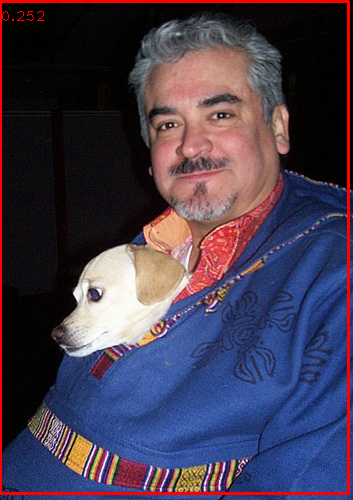

In [ ]:
#  Let's try to perform inference for single image

def predict_gpu(model,image_name):
    
    image = cv2.imread(image_name)       
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    h,w,_ = image.shape
    img = cv2.resize(image,(448,448)) 
    
    # Do remember that the following transform only accepts input to be numpy array instead PIL image
    # Therefore, the previously-defined transfroms() can't be used here
    transform = transforms.Compose([transforms.ToTensor(),transforms.Normalize([0.485, 0.456, 0.406], [1, 1, 1])])
    # image is an torch tensor    
    img = transform(img)*255    
    #  None = NP.newaxis and the reason why doing this is that model inference would only accept 4-d torch tensor.
    img = Variable(img[None,:,:,:])
    img = img.cuda()
        
    pred= model(img)
    # detection_classses contains object id and its confidence
    boxes, detection_classses = yolo_box_decoder(pred,conf_thresh=0.2,nms_thresh=0.5)
    
    return boxes,detection_classses
 
def plot_boxes_cv2(img, boxes, detection_classses, class_names=None, color=None):

    width = img.shape[1]
    height = img.shape[0]    

    for j in range(len(boxes)):
        
        x1 = boxes[j,0]
        y1 = boxes[j,1]
        x2 = x1 + boxes[j,2]
        y2 = y1 + boxes[j,3]
        x1,x2 = int(x1*width),int(x2*width)
        y1,y2 = int(y1*height),int(y2*height)
        
        cls_id = int(detection_classses[j,0])
        prob = float(detection_classses[j,1])
        print(prob)

        img = cv2.putText(img, class_names[cls_id], (x1,y1),  cv2.FONT_HERSHEY_PLAIN, 1.0, (0,0,255), thickness=1)
        img = cv2.putText(img, str(round(prob,3)), (x1,y1+20),  cv2.FONT_HERSHEY_PLAIN, 1.0, (0,0,255), thickness=1)
        img = cv2.rectangle(img, (x1,y1), (x2,y2), (0, 0, 255), 2)
            
    return img

model = YOLO(cls_num, bbox_num, box_scale)
model.eval()
# 1. load your best model trained so far.
#model.load_state_dict(torch.load( model_path + 'best_.pkl'))
# 2. load example model trained for only a few epochs
#model.load_state_dict(torch.load( model_path + 'example_model_mAP14.1.pkl'))
model.load_state_dict(torch.load( model_path + 'best_mAP33.6.pkl'))


model.cuda()
        
# testing image
image_name = VOC_root_dir + "VOCdevkit/VOC2007/JPEGImages/000001.jpg"
#image_name = VOC_root_dir + "testing_imgs/car_only.jpg"
#image_name = VOC_root_dir + "testing_imgs/beauty_only.jpg"
#image_name = VOC_root_dir + "testing_imgs/car_n_beauty.jpg"
 
image = cv2.imread(image_name)
# performing inference           
boxes, detection_classses = predict_gpu(model,image_name)
# overlapping detection bounding box
image = plot_boxes_cv2(image, boxes, detection_classses, class_names = classes, color=None)
   
cv2_imshow(image)    


### 調整Learning Rate對結果的影響
- 這裡測試三組Learning Rate = 2E-5, 2E-4, 2E-3，最終的結果呈現都一樣
- 不過在測試時，經過9 epochs, Best AP = 0.116(2E-5), 0.044(2E-4), AssertionError(2E-3)
- 在 YOLOv1 中，學習率對辨識率的影響與其他深度學習模型類似。在訓練過程中，學習率控制了模型參數的更新速度。如果學習率太小，模型更新的速度會非常緩慢，可能需要更長的時間才能達到最優解，甚至有可能陷入局部最優解中。如果學習率太大，模型更新的速度會非常快，可能會導致模型在訓練過程中發生震盪，無法收斂到最優解。